<a href="https://colab.research.google.com/github/ashrafulwork/TrafficVisionBD/blob/analyze%2Ftesting/TrafficVisionBD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#First we need to setup our envrionment before we even start training our model

In [1]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


Installing kaggle

In [2]:
!pip install kaggle

Uploading kaggle.json file ( make sure to upload your own json file)

In [3]:
from google.colab import files
files.upload()  # This will prompt you to upload the kaggle.json file

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mdashrafulhossain","key":"acc5ad91a973f1b6ab7b3cfd1f6eff38"}'}

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Here we passed the dataset path/link

In [5]:
!kaggle datasets download -d hasibzunair/rsud20k-bangladesh-road-scene-understanding # Replace 'datasetname' with your dataset's identifier


Dataset URL: https://www.kaggle.com/datasets/hasibzunair/rsud20k-bangladesh-road-scene-understanding
License(s): Attribution-NonCommercial 4.0 International (CC BY-NC 4.0)
100% 10.2G/10.2G [02:22<00:00, 68.7MB/s]
100% 10.2G/10.2G [02:22<00:00, 77.2MB/s]


The dataset is now uploaded as a ZIP file. Now we need to upload/extract the zip file

In [6]:
import zipfile
import os

# Assuming the dataset is in a single zip file, e.g., 'datasetname.zip'
with zipfile.ZipFile("rsud20k-bangladesh-road-scene-understanding.zip", 'r') as zip_ref:
    zip_ref.extractall("RSUD20k")  # Replace with your preferred directory


# Data Analysis and exploration starts

Now let us see some samples of our dataset

Found 20334 images belonging to 2 classes.


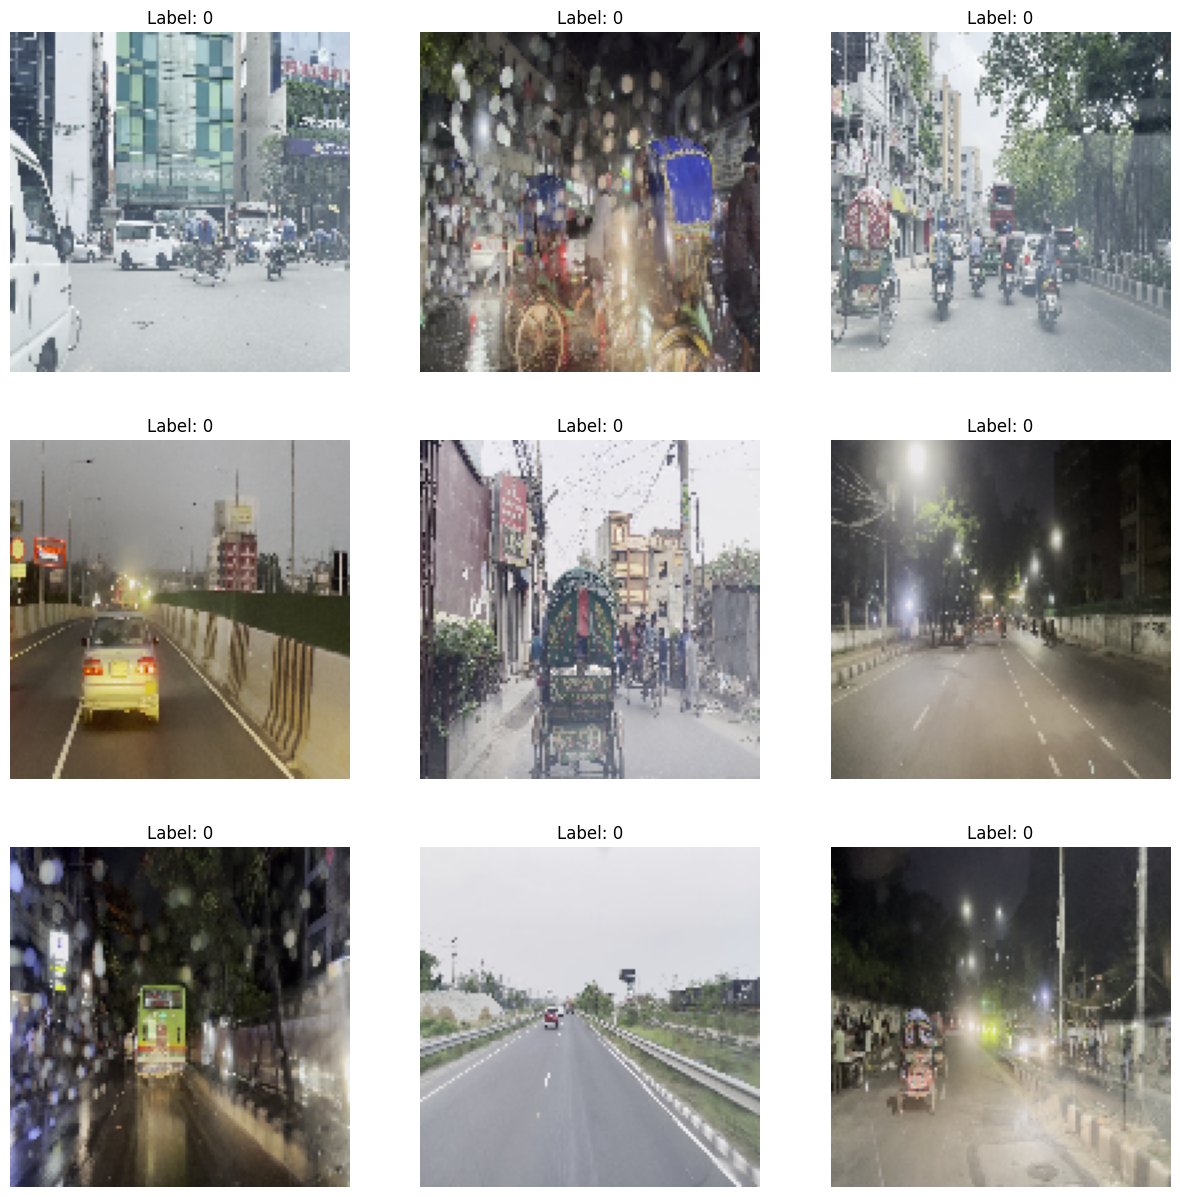

In [7]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

# Set up ImageDataGenerator to load images with labels
data_dir = '/content/RSUD20k'  # Replace with the path where images are extracted

# Load images directly from the directory
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0 / 255)
data = datagen.flow_from_directory(
    data_dir,
    target_size=(128, 128),  # Resize images to 128x128 (adjust as needed)
    batch_size=32,
    class_mode='binary'  # Change to 'categorical' if you have more than 2 classes
)

# Display a batch of images
def show_images(images, labels):
    plt.figure(figsize=(15, 15))
    for i in range(9):  # Display 9 images
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(f"Label: {int(labels[i])}")
        plt.axis("off")
    plt.show()

# Get a batch of images and labels
images, labels = next(data)
show_images(images, labels)


Classes found: ['train', 'val', 'test']
Class 'train': 18681 images
Class 'val': 1004 images
Class 'test': 649 images


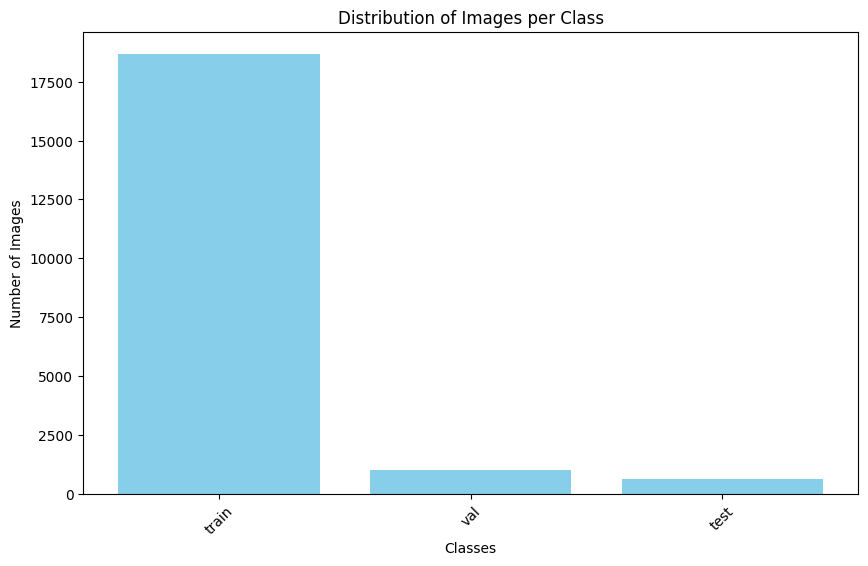

In [8]:
import os
import matplotlib.pyplot as plt

# Define the path to your dataset
dataset_path = '/content/RSUD20k/images'  # Change this to the path of your dataset

# Initialize an empty dictionary to store image counts per class
class_counts = {}
# Check if the path exists
if not os.path.exists(dataset_path):
    print("Dataset path does not exist.")
else:
    # List the directories within the dataset path
    classes = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]
    print("Classes found:", classes)

    # Iterate over each class folder and count images
    for class_name in classes:
        class_folder = os.path.join(dataset_path, class_name)
        image_count = len([img for img in os.listdir(class_folder) if img.endswith(('.png', '.jpg', '.jpeg'))])
        class_counts[class_name] = image_count
        print(f"Class '{class_name}': {image_count} images")

# If no classes are found, show a message
if not class_counts:
    print("No images found in the specified path.")
else:
    # Convert the dictionary to lists for plotting
    class_names = list(class_counts.keys())
    image_counts = list(class_counts.values())

    # Plotting the distribution
    plt.figure(figsize=(10, 6))
    plt.bar(class_names, image_counts, color='skyblue')
    plt.xlabel('Classes')
    plt.ylabel('Number of Images')
    plt.title('Distribution of Images per Class')
    plt.xticks(rotation=45)
    plt.show()


In [9]:
import os
import hashlib
from PIL import Image

# Define the path to your dataset
dataset_path = '/content/RSUD20k'  # Change this to the path of your dataset

# Initialize dictionaries to store image hashes and track duplicates
image_hashes = {}
duplicates = []
corrupt_images = []

# Function to calculate the hash of an image
def calculate_hash(image_path):
    with open(image_path, 'rb') as f:
        img_hash = hashlib.md5(f.read()).hexdigest()
    return img_hash

# Loop through each class folder and each image
for root, dirs, files in os.walk(dataset_path):
    for file in files:
        if file.endswith(('.png', '.jpg', '.jpeg')):
            image_path = os.path.join(root, file)

            # Check for corrupt images
            try:
                with Image.open(image_path) as img:
                    img.verify()  # Verify that the image is valid
            except (IOError, SyntaxError) as e:
                print(f"Corrupt image detected: {image_path}")
                corrupt_images.append(image_path)
                continue

            # Calculate hash for duplicate detection
            img_hash = calculate_hash(image_path)
            if img_hash in image_hashes:
                print(f"Duplicate image found: {image_path} and {image_hashes[img_hash]}")
                duplicates.append((image_path, image_hashes[img_hash]))
            else:
                image_hashes[img_hash] = image_path

# Summary of issues
print("\nSummary of Issues:")
print(f"Total duplicate images: {len(duplicates)}")
for dup1, dup2 in duplicates:
    print(f"Duplicate pair: {dup1}, {dup2}")

print(f"Total corrupt images: {len(corrupt_images)}")
for corrupt in corrupt_images:
    print(f"Corrupt image: {corrupt}")



Summary of Issues:
Total duplicate images: 0
Total corrupt images: 0


In [10]:
import os
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
import numpy as np

# Define paths
images_path = "/content/RSUD20k/images/train"  # Update this path
labels_path = "/content/RSUD20k/labels/train"  # Update this path

# Load class names (assuming a file with names or define them manually)
class_names = ["person", "rickshaw", "rickshaw van", "auto rickshaw","truck " ,"pickup truck" ,"private car" ,"motorcycle" ,"bicycle" ,"bicycle" ,"micro bus" ,"covered van" ,"covered van"]  # Update according to your dataset


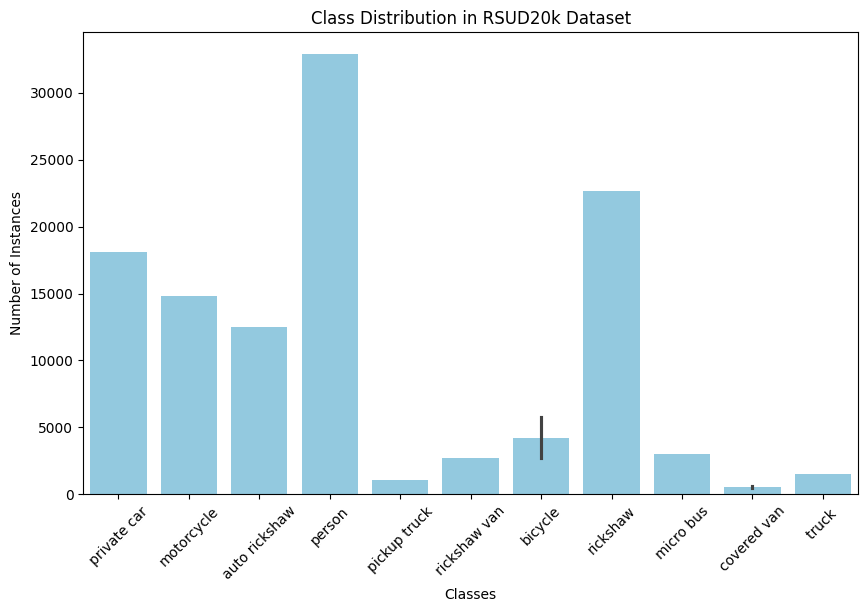

In [11]:
from collections import Counter

# Count occurrences of each class in labels
class_counts = Counter()

for label_file in os.listdir(labels_path):
    with open(os.path.join(labels_path, label_file), 'r') as f:
        for line in f:
            class_id = int(line.split()[0])
            class_counts[class_id] += 1

# Plot class distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=[class_names[c] for c in class_counts.keys()], y=list(class_counts.values()), color="skyblue")
plt.xlabel("Classes")
plt.ylabel("Number of Instances")
plt.title("Class Distribution in RSUD20k Dataset")
plt.xticks(rotation=45)
plt.show()


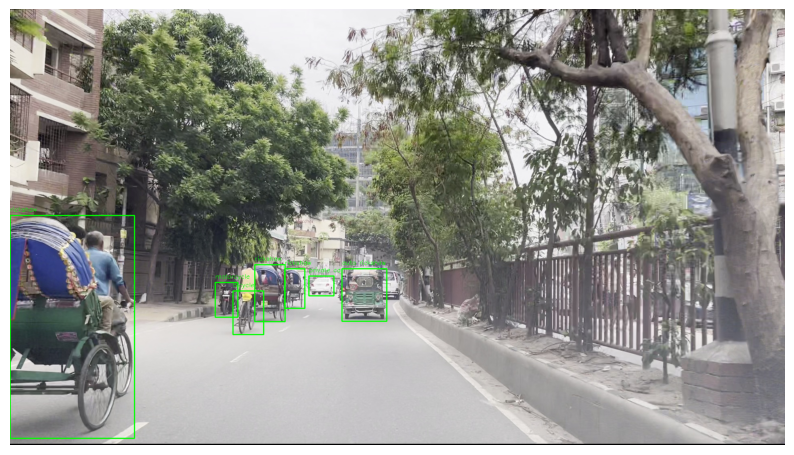

In [12]:
def plot_image_with_bboxes(image_path, label_path):
    image = cv2.imread(image_path)
    h, w, _ = image.shape

    with open(label_path, 'r') as f:
        for line in f:
            class_id, cx, cy, bw, bh = map(float, line.strip().split())
            x1 = int((cx - bw / 2) * w)
            y1 = int((cy - bh / 2) * h)
            x2 = int((cx + bw / 2) * w)
            y2 = int((cy + bh / 2) * h)

            cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(image, class_names[int(class_id)], (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

# Example visualization
sample_image = os.path.join(images_path, "/content/RSUD20k/images/train/train0.jpg")  # Update with a sample image
sample_label = os.path.join(labels_path, "/content/RSUD20k/labels/train/train0.txt")   # Update with the corresponding label
plot_image_with_bboxes(sample_image, sample_label)


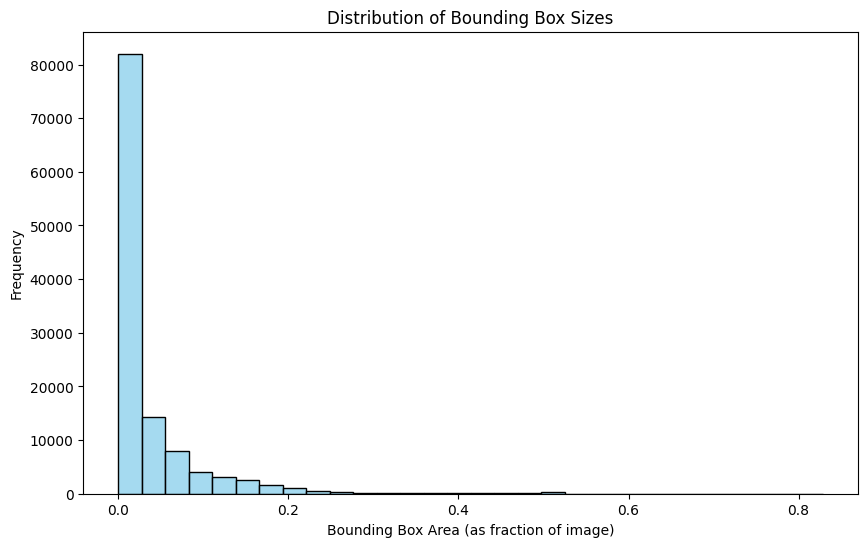

In [13]:
box_areas = []

for label_file in os.listdir(labels_path):
    with open(os.path.join(labels_path, label_file), 'r') as f:
        for line in f:
            _, _, _, bw, bh = map(float, line.strip().split())
            box_areas.append(bw * bh)

plt.figure(figsize=(10, 6))
sns.histplot(box_areas, bins=30, color='skyblue')
plt.xlabel("Bounding Box Area (as fraction of image)")
plt.ylabel("Frequency")
plt.title("Distribution of Bounding Box Sizes")
plt.show()


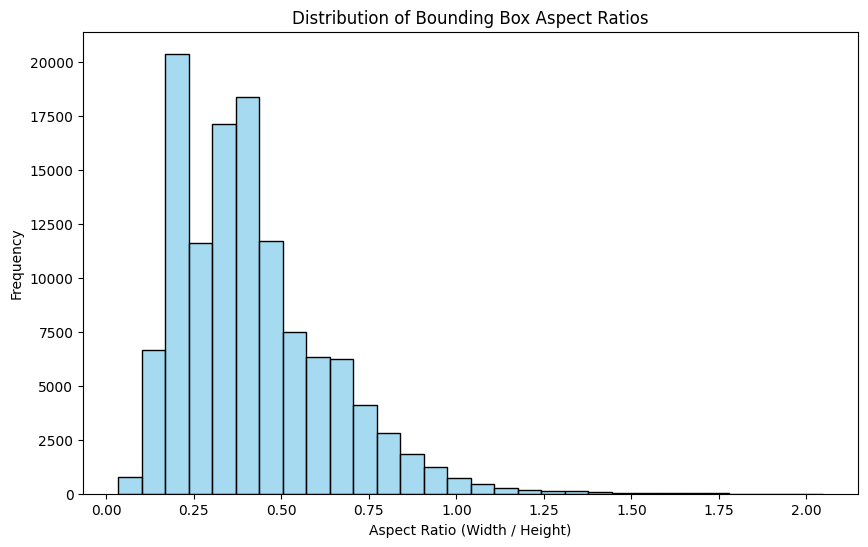

In [14]:
aspect_ratios = []

for label_file in os.listdir(labels_path):
    with open(os.path.join(labels_path, label_file), 'r') as f:
        for line in f:
            _, _, _, bw, bh = map(float, line.strip().split())
            aspect_ratios.append(bw / bh)

plt.figure(figsize=(10, 6))
sns.histplot(aspect_ratios, bins=30, color='skyblue')
plt.xlabel("Aspect Ratio (Width / Height)")
plt.ylabel("Frequency")
plt.title("Distribution of Bounding Box Aspect Ratios")
plt.show()


Image with most bounding boxes: train5171.txt with 25 boxes


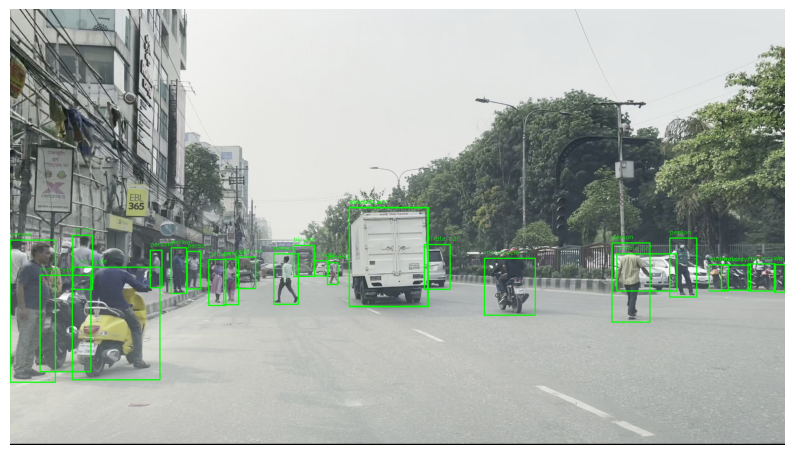

In [15]:
max_bboxes = 0
max_bboxes_image = ""

for label_file in os.listdir(labels_path):
    with open(os.path.join(labels_path, label_file), 'r') as f:
        bbox_count = len(f.readlines())
        if bbox_count > max_bboxes:
            max_bboxes = bbox_count
            max_bboxes_image = label_file

# Display the image with the most bounding boxes
image_path = os.path.join(images_path, max_bboxes_image.replace('.txt', '.jpg'))  # Update extension if needed
label_path = os.path.join(labels_path, max_bboxes_image)
print(f"Image with most bounding boxes: {max_bboxes_image} with {max_bboxes} boxes")
plot_image_with_bboxes(image_path, label_path)


In [16]:
import os
print(os.path.exists("/content/image.png"))


False


In [17]:
#checking maximum number of class

In [18]:
import os

label_dir = '/content/RSUD20k/labels/train'  # Path to your label directory
classes_count = 13  # Total number of classes

# Function to fix the labels
def fix_labels(label_file):
    with open(label_file, 'r') as file:
        lines = file.readlines()

    corrected_lines = []
    for line in lines:
        parts = line.strip().split()
        class_id = int(parts[0])
        if class_id >= classes_count:  # If class ID is greater than 12, we correct it
            print(f"Correcting label {line.strip()} in {label_file}")
            class_id = class_id % classes_count  # Assign a valid class ID
        corrected_line = f"{class_id} " + " ".join(parts[1:])
        corrected_lines.append(corrected_line)

    with open(label_file, 'w') as file:
        file.writelines([line + '\n' for line in corrected_lines])

# Iterate over label files and fix them
for label_file in os.listdir(label_dir):
    if label_file.endswith('.txt'):
        fix_labels(os.path.join(label_dir, label_file))


In [19]:
import os

image_dir = '/content/RSUD20k/images/train'
label_dir = '/content/RSUD20k/labels/train'

# Check for missing or empty label files
missing_labels = []
empty_labels = []

for image_file in os.listdir(image_dir):
    if image_file.endswith('.jpg'):  # assuming your images are in JPG format
        label_file = image_file.replace('.jpg', '.txt')
        label_path = os.path.join(label_dir, label_file)

        if not os.path.exists(label_path):
            missing_labels.append(label_file)
        else:
            with open(label_path, 'r') as file:
                if len(file.readlines()) == 0:  # Empty label file
                    empty_labels.append(label_file)

print("Missing label files:", missing_labels)
print("Empty label files:", empty_labels)


Missing label files: []
Empty label files: []


In [20]:
#DATASEt 2

In [21]:
!kaggle competitions download -c dl-enigma-10-sust-cse-carnival-2024

100% 3.21G/3.23G [00:37<00:00, 41.7MB/s]
100% 3.23G/3.23G [00:37<00:00, 91.3MB/s]


In [22]:
import zipfile
import os

# Assuming the dataset is in a single zip file, e.g., 'datasetname.zip'
with zipfile.ZipFile("/content/dl-enigma-10-sust-cse-carnival-2024.zip", 'r') as zip_ref:
    zip_ref.extractall("BadODD")  # Replace with your preferred directory


Found 7860 images belonging to 2 classes.


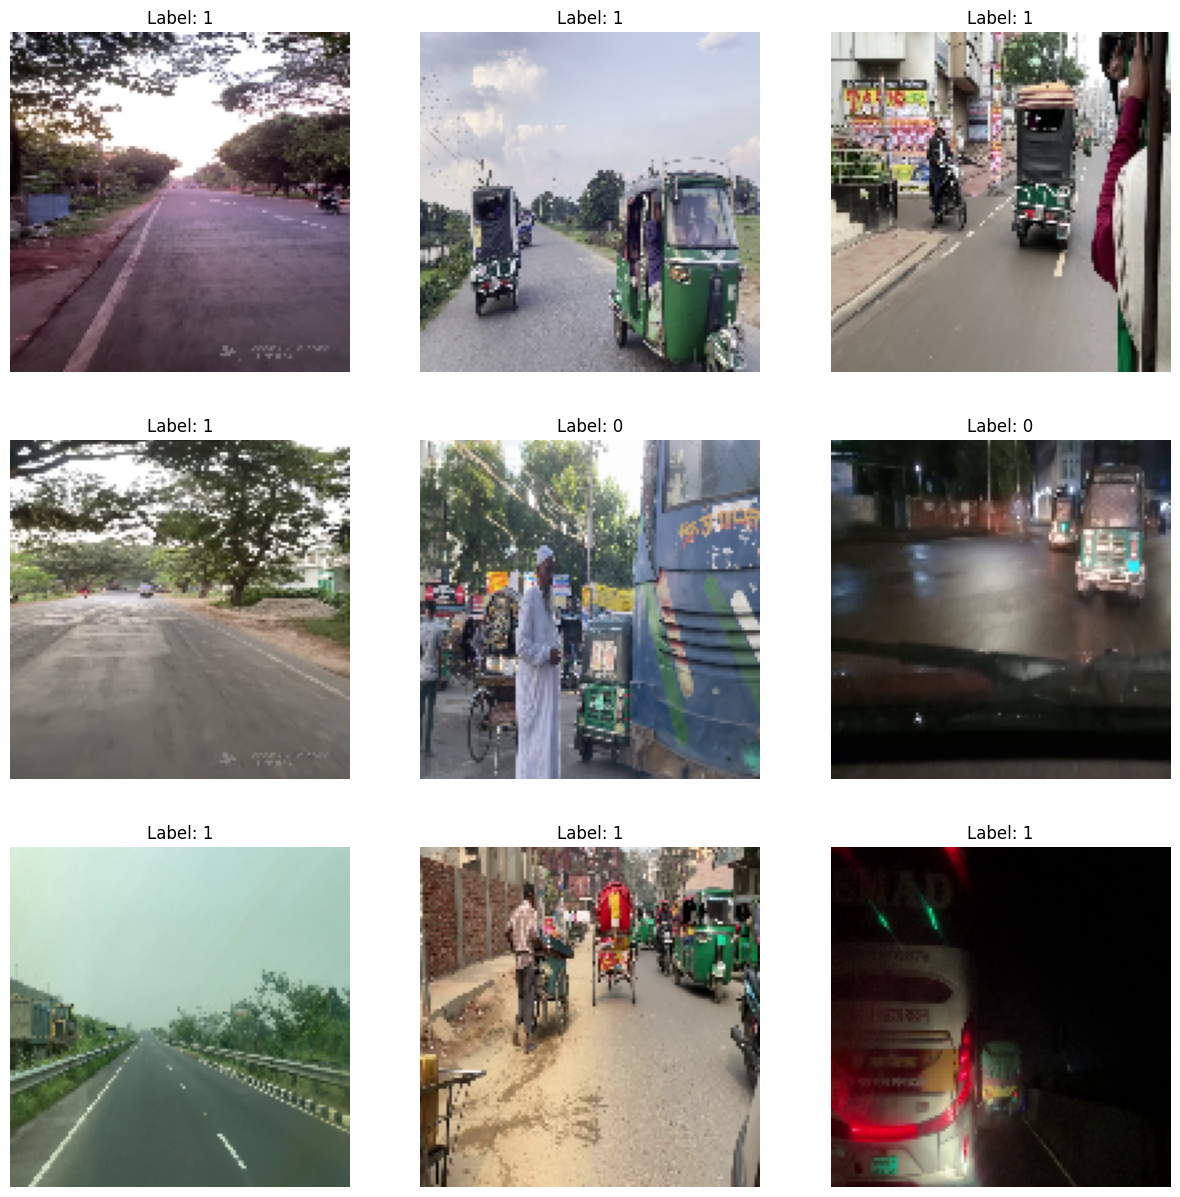

In [23]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

# Set up ImageDataGenerator to load images with labels
data_dir = '/content/BadODD/dlenigma1/BadODD/images'  # Replace with the path where images are extracted

# Load images directly from the directory
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0 / 255)
data = datagen.flow_from_directory(
    data_dir,
    target_size=(128, 128),  # Resize images to 128x128 (adjust as needed)
    batch_size=32,
    class_mode='binary'  # Change to 'categorical' if you have more than 2 classes
)

# Display a batch of images
def show_images(images, labels):
    plt.figure(figsize=(15, 15))
    for i in range(9):  # Display 9 images
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(f"Label: {int(labels[i])}")
        plt.axis("off")
    plt.show()

# Get a batch of images and labels
images, labels = next(data)
show_images(images, labels)


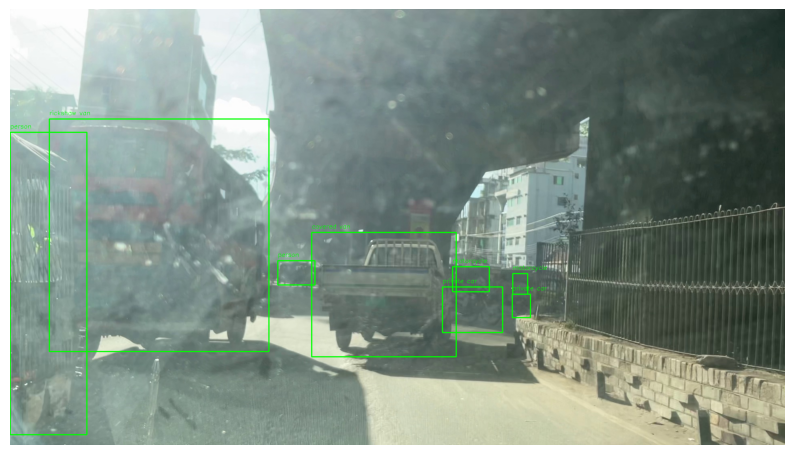

In [24]:
def plot_image_with_bboxes(image_path, label_path):
    image = cv2.imread(image_path)
    h, w, _ = image.shape

    with open(label_path, 'r') as f:
        for line in f:
            class_id, cx, cy, bw, bh = map(float, line.strip().split())
            x1 = int((cx - bw / 2) * w)
            y1 = int((cy - bh / 2) * h)
            x2 = int((cx + bw / 2) * w)
            y2 = int((cy + bh / 2) * h)

            cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(image, class_names[int(class_id)], (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

# Example visualization
sample_image = os.path.join(images_path, "/content/BadODD/dlenigma1/BadODD/images/train/chittagong_bohoddarhat1_12154.jpg")  # Update with a sample image
sample_label = os.path.join(labels_path, "/content/BadODD/dlenigma1/BadODD/labels/train/chittagong_bohoddarhat1_12154.txt")   # Update with the corresponding label
plot_image_with_bboxes(sample_image, sample_label)


In [25]:
import os

# Path to the directory containing label files
labels_path = '/content/BadODD/dlenigma1/BadODD/labels/train'  # Replace with your labels directory path

# Set to store unique class IDs
class_ids = set()

# Loop through each label file to gather unique class IDs
for label_file in os.listdir(labels_path):
    if label_file.endswith(".txt"):  # Make sure to only read .txt files
        with open(os.path.join(labels_path, label_file), 'r') as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) >= 1:
                    class_ids.add(int(parts[0]))  # Assuming the first value is the class ID

# Display the unique class IDs found
print("Unique Class IDs:", class_ids)


Unique Class IDs: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12}


In [28]:
# Define paths
BadODD_images_path = "/content/BadODD/dlenigma1/BadODD/images/train"  # Update this path
BadODD_labels_path = "/content/BadODD/dlenigma1/BadODD/labels/train"  # Update this path

# Load class names (assuming a file with names or define them manually)
class_names = ["auto_rickshaw", "bicycle", "bus", "car","cart_vehicle " ,"construction_vehicle" ,"motorbike" ,"person" ,"priority_vehicle" ,"three_wheeler" ,"train" ,"truck" ,"wheelchair"]  # Update according to your dataset


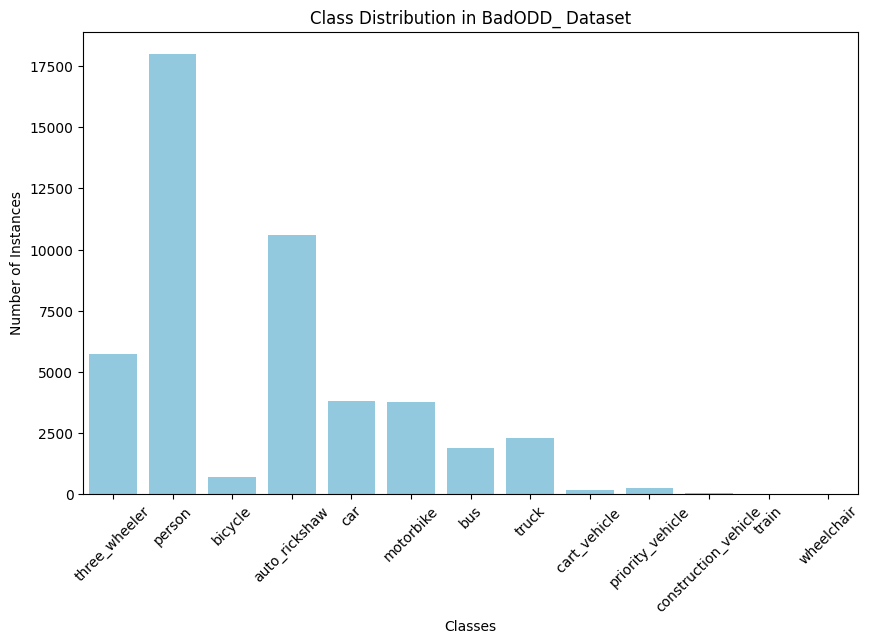

In [29]:
from collections import Counter

# Count occurrences of each class in labels
class_counts = Counter()

for label_file in os.listdir(BadODD_labels_path):
    with open(os.path.join(BadODD_labels_path, label_file), 'r') as f:
        for line in f:
            class_id = int(line.split()[0])
            class_counts[class_id] += 1

# Plot class distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=[class_names[c] for c in class_counts.keys()], y=list(class_counts.values()), color="skyblue")
plt.xlabel("Classes")
plt.ylabel("Number of Instances")
plt.title("Class Distribution in BadODD_ Dataset")
plt.xticks(rotation=45)
plt.show()


Image with most bounding boxes: maowa_expressway2_44722.txt with 37 boxes


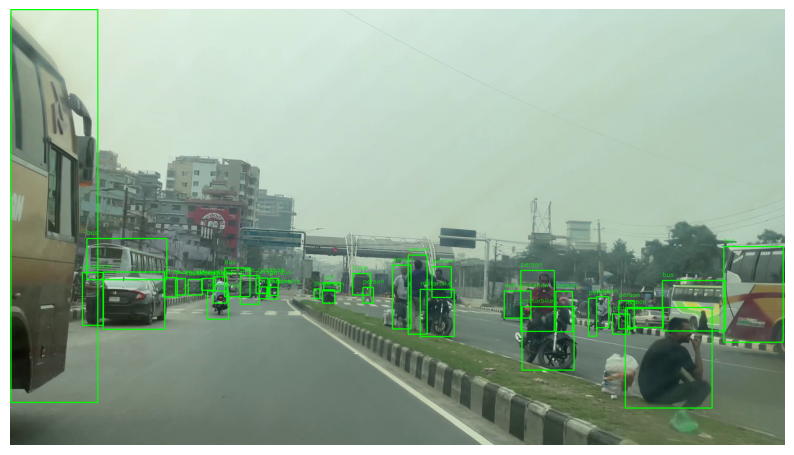

In [37]:
# Define paths
BadODD_images_path = "/content/BadODD/dlenigma1/BadODD/images/train"  # Update this path
BadODD_labels_path = "/content/BadODD/dlenigma1/BadODD/labels/train"  # Update this path

# Load class names (assuming a file with names or define them manually)
class_names = ["auto_rickshaw", "bicycle", "bus", "car", "cart_vehicle",
               "construction_vehicle", "motorbike", "person", "priority_vehicle",
               "three_wheeler", "train", "truck", "wheelchair"]  # Update according to your dataset

max_bboxes = 0
max_bboxes_image = ""

# Find the image with the most bounding boxes
for label_file in os.listdir(BadODD_labels_path):
    label_file_path = os.path.join(BadODD_labels_path, label_file)
    with open(label_file_path, 'r') as f:
        bbox_count = len(f.readlines())
        if bbox_count > max_bboxes:
            max_bboxes = bbox_count
            max_bboxes_image = label_file

# Define image and label paths for the selected image
image_path = os.path.join(BadODD_images_path, max_bboxes_image.replace('.txt', '.jpg'))  # Update extension if needed
label_path = os.path.join(BadODD_labels_path, max_bboxes_image)

print(f"Image with most bounding boxes: {max_bboxes_image} with {max_bboxes} boxes")

# Call plot_image_with_bboxes with the specific label file
plot_image_with_bboxes(image_path, label_path)  # Pass label_path, not the directory


In [26]:
dasdasdas

NameError: name 'dasdasdas' is not defined

In [39]:
!kaggle datasets download -d sazedcse17/vehicle-bd-dataset # Replace 'datasetname' with your dataset's identifier


Dataset URL: https://www.kaggle.com/datasets/sazedcse17/vehicle-bd-dataset
License(s): CC0-1.0
100% 4.19G/4.21G [00:58<00:00, 68.5MB/s]
100% 4.21G/4.21G [00:58<00:00, 77.0MB/s]


In [94]:
import zipfile
import os

# Assuming the dataset is in a single zip file, e.g., 'datasetname.zip'
with zipfile.ZipFile("/content/vehicle-bd-dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("Vehicle_Images_Dataset")  # Replace with your preferred directory




Found 13498 images belonging to 1 classes.


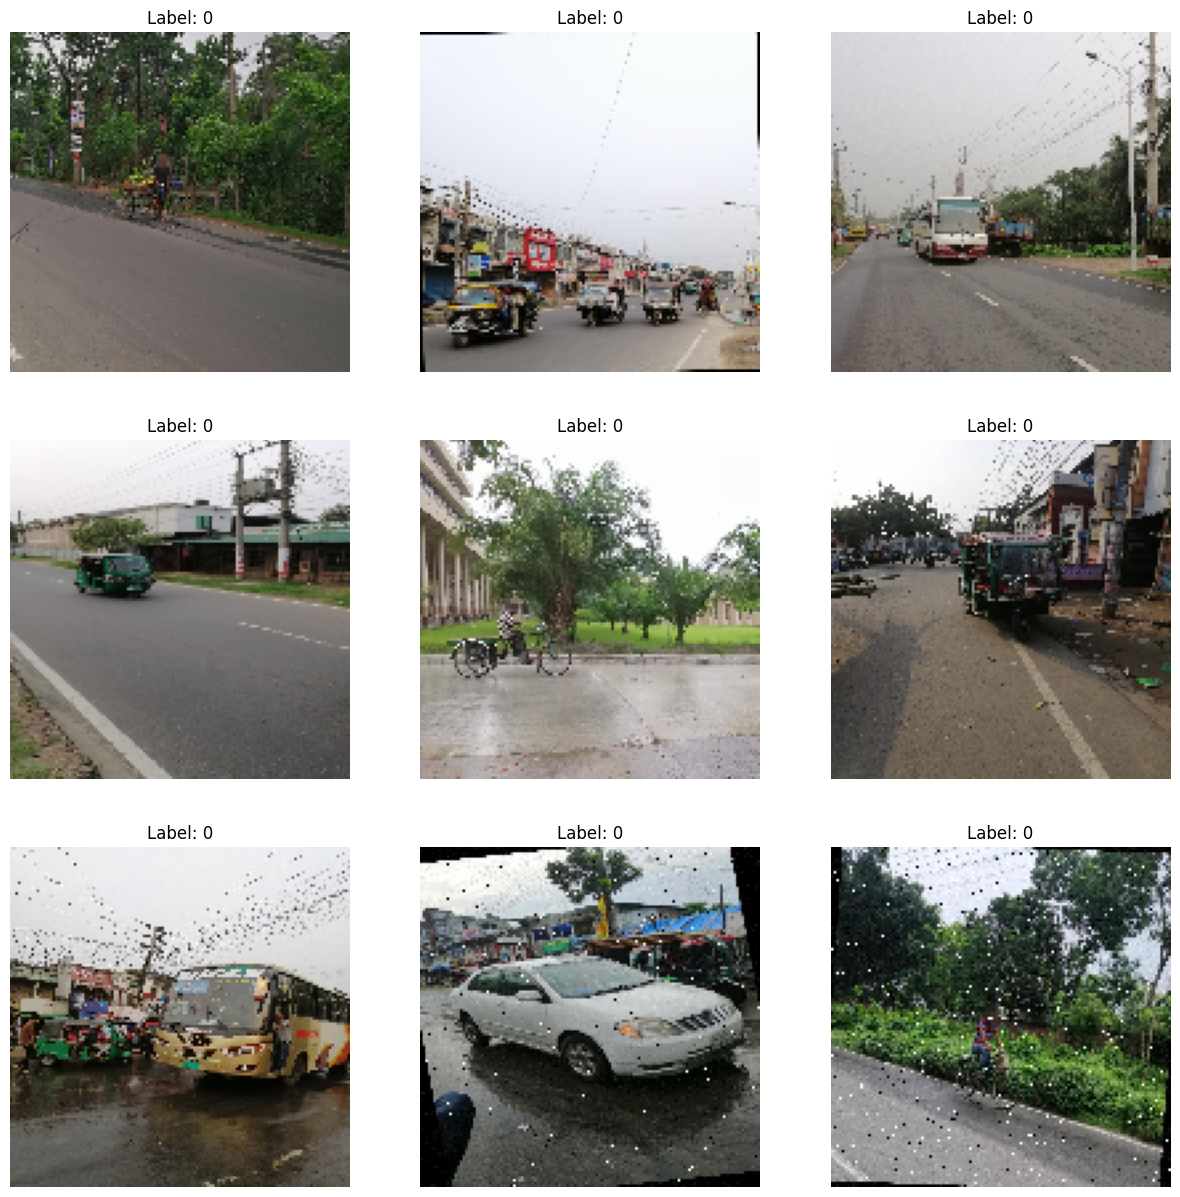

In [95]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

# Set up ImageDataGenerator to load images with labels
data_dir = '/content/Vehicle_Images_Dataset'  # Replace with the path where images are extracted

# Load images directly from the directory
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0 / 255)
data = datagen.flow_from_directory(
    data_dir,
    target_size=(128, 128),  # Resize images to 128x128 (adjust as needed)
    batch_size=32,
    class_mode='binary'  # Change to 'categorical' if you have more than 2 classes
)

# Display a batch of images
def show_images(images, labels):
    plt.figure(figsize=(15, 15))
    for i in range(9):  # Display 9 images
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(f"Label: {int(labels[i])}")
        plt.axis("off")
    plt.show()

# Get a batch of images and labels
images, labels = next(data)
show_images(images, labels)


In [83]:
import os
import shutil

# Define paths to the source subfolders and target folders
source_folder = '/content/Vehicle_Images_Dataset/Final Public Dataset/After Augmentation'  # Parent folder containing subfolders
target_images_folder = '/content/Vehicle_Images_Dataset/Final Public Dataset/After Augmentation/Images'  # Target folder for images
target_labels_folder = '/content/Vehicle_Images_Dataset/Final Public Dataset/After Augmentation/Labels'  # Target folder for labels

# Check if the target folders exist, create them if not
os.makedirs(target_images_folder, exist_ok=True)
os.makedirs(target_labels_folder, exist_ok=True)

# Counters for moved images and labels
moved_images = 0
moved_labels = 0

# Iterate through all the subfolders in the source folder
for subfolder in os.listdir(source_folder):
    subfolder_path = os.path.join(source_folder, subfolder)

    if os.path.isdir(subfolder_path):
        # Move image files to the target_images_folder
        for file in os.listdir(subfolder_path):
            if file.endswith(('.png', '.jpg', '.jpeg')):  # Image file extensions
                source_image = os.path.join(subfolder_path, file)
                target_image = os.path.join(target_images_folder, file)

                # Move the image file
                shutil.move(source_image, target_image)
                moved_images += 1  # Increment the counter for moved images
                print(f"Moved image: {file}")

            # Move label files to the target_labels_folder
            elif file.endswith('.xml'):  # Label file extension (adjust if different)
                source_label = os.path.join(subfolder_path, file)
                target_label = os.path.join(target_labels_folder, file)

                # Move the label file
                shutil.move(source_label, target_label)
                moved_labels += 1  # Increment the counter for moved labels
                print(f"Moved label: {file}")

# Print the final count of moved files
print(f"\nTotal images moved: {moved_images}")
print(f"Total labels moved: {moved_labels}")


Streaming output truncated to the last 5000 lines.
Moved image: IMG_20220528_072054_jpg.rf.0722d134d1683b4a0dbd2da9f5f6dd21.jpg
Moved image: IMG_20220527_174650_1_jpg.rf.8e2613cde1afe38b8600a921bce22d80.jpg
Moved image: IMG_20220601_102453_1_jpg.rf.fd830c6daa062160b31f941243e5386e.jpg
Moved image: IMG_20220528_073320_jpg.rf.fbcaf8d87bee89f9d8c33b563531fbb4.jpg
Moved image: IMG_20220528_073136_2_jpg.rf.04e42a9bb95b7595bd50527d255f3f65.jpg
Moved image: IMG_20220529_174152_jpg.rf.a9ed0889c9555be86a4343f542ffead2.jpg
Moved image: IMG_20220529_174732_2_jpg.rf.1b25fd3d87662d07f05936ffbaf8c673.jpg
Moved image: IMG_20220601_105431_1_jpg.rf.51034bd3625832f28554196422e4c6d6.jpg
Moved image: IMG_20220618_133407_1_jpg.rf.91dcfc6f08c355cb41c6f370a9961639.jpg
Moved image: IMG_20220601_105135_1_jpg.rf.3e8dc87b95b02f3becbaa9ceb9882d4c.jpg
Moved image: IMG_20220527_175427_1_jpg.rf.c6d455376a1461c4bd9b79f9686061f2.jpg
Moved image: IMG_20220601_101955_2_jpg.rf.b35389933ee17b6a45256eec8a832d5a.jpg
Moved i

In [86]:
import os
import xml.etree.ElementTree as ET

# Define the paths for XML and TXT files
xml_folder = '/content/Vehicle_Images_Dataset/Final Public Dataset/After Augmentation/Labels'  # Folder containing XML files
txt_folder = '/content/Vehicle_Images_Dataset/Final Public Dataset/After Augmentation/Labels_TXT'  # Folder to save TXT files

# Ensure the TXT folder exists
os.makedirs(txt_folder, exist_ok=True)

# List of class names (as per your dataset)
class_names = [
    "auto_rickshaw", "bicycle", "bus", "car", "cart_vehicle", "construction_vehicle",
    "motorbike", "person", "priority_vehicle", "three_wheeler", "train", "truck", "wheelchair"
]

# Function to convert XML to TXT
def convert_xml_to_txt(xml_file, txt_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    # Open the TXT file for writing
    with open(txt_file, 'w') as f:
        # Extract image size
        width = int(root.find('size/width').text)
        height = int(root.find('size/height').text)

        # Loop through each object in the XML
        for obj in root.findall('object'):
            class_name = obj.find('name').text
            if class_name in class_names:
                class_id = class_names.index(class_name)  # Get class ID from class_names list

                # Get the bounding box coordinates
                bbox = obj.find('bndbox')
                xmin = int(bbox.find('xmin').text)
                ymin = int(bbox.find('ymin').text)
                xmax = int(bbox.find('xmax').text)
                ymax = int(bbox.find('ymax').text)

                # Convert to YOLO format: class_id, x_center, y_center, width, height (normalized)
                x_center = (xmin + xmax) / 2 / width
                y_center = (ymin + ymax) / 2 / height
                w = (xmax - xmin) / width
                h = (ymax - ymin) / height

                # Write the result to the TXT file
                f.write(f"{class_id} {x_center} {y_center} {w} {h}\n")

# Iterate over all XML files in the source folder
moved_files = 0
for xml_file in os.listdir(xml_folder):
    if xml_file.endswith('.xml'):
        xml_path = os.path.join(xml_folder, xml_file)
        txt_filename = xml_file.replace('.xml', '.txt')
        txt_path = os.path.join(txt_folder, txt_filename)

        # Convert the XML to TXT
        convert_xml_to_txt(xml_path, txt_path)
        moved_files += 1  # Increment the counter for moved files
        print(f"Converted XML: {xml_file} to TXT")

# Print the total number of files converted
print(f"\nTotal XML files converted to TXT: {moved_files}")


Streaming output truncated to the last 5000 lines.
Converted XML: photo_2022-06-16_11-06-52_jpg.rf.3bbc12368612fb360c181f840325b81a.xml to TXT
Converted XML: IMG_20220601_105408_2_jpg.rf.31484c68fd5a8a912d01bf8a52ae5f57.xml to TXT
Converted XML: IMG_20220529_181519_2_jpg.rf.6d8ea1c517e0ce241a6b4a49bdce5281.xml to TXT
Converted XML: photo_2022-06-21_13-50-51_jpg.rf.af9d2061021f1ed04c24105182670f97.xml to TXT
Converted XML: IMG_20220601_103934_jpg.rf.c34d0e8d5d94e481dc8444149b821ba8.xml to TXT
Converted XML: IMG_20220527_175242_jpg.rf.c73d3f8b5c79136241a911a08bd62360.xml to TXT
Converted XML: IMG_20220527_173406_1_jpg.rf.169c86c8c7abab59a218bbd155fcc42b.xml to TXT
Converted XML: IMG_20220618_133108_jpg.rf.46528af0208343bebdb088a54ea80e48.xml to TXT
Converted XML: IMG_20220618_143527_jpg.rf.b0a15d054624567e87a89734234832f6.xml to TXT
Converted XML: IMG_20220527_181822_jpg.rf.5e1fdd5aaab2824fcbd83bfd4d676061.xml to TXT
Converted XML: IMG_20220619_165527_3_jpg.rf.0741a3d723c59077d6149b0dc32

In [87]:
import os
import shutil

# Define the paths to the folders to keep
folders_to_keep = [
    '/content/Vehicle_Images_Dataset/Final Public Dataset/After Augmentation/Labels_TXT',
    '/content/Vehicle_Images_Dataset/Final Public Dataset/After Augmentation/Main_Images'
]

# Define the root directory
root_dir = '/content/Vehicle_Images_Dataset/Final Public Dataset/After Augmentation'

# List all subfolders
subfolders = [f for f in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, f))]

# Iterate over each subfolder
for folder in subfolders:
    folder_path = os.path.join(root_dir, folder)

    # Delete the folder if it's not in the list of folders to keep
    if folder_path not in folders_to_keep:
        shutil.rmtree(folder_path)
        print(f"Deleted folder: {folder_path}")

print("Deletion process completed.")


Deleted folder: /content/Vehicle_Images_Dataset/Final Public Dataset/After Augmentation/Car
Deleted folder: /content/Vehicle_Images_Dataset/Final Public Dataset/After Augmentation/Van
Deleted folder: /content/Vehicle_Images_Dataset/Final Public Dataset/After Augmentation/Easy bike
Deleted folder: /content/Vehicle_Images_Dataset/Final Public Dataset/After Augmentation/Multi-Class
Deleted folder: /content/Vehicle_Images_Dataset/Final Public Dataset/After Augmentation/Bicycle
Deleted folder: /content/Vehicle_Images_Dataset/Final Public Dataset/After Augmentation/CNG
Deleted folder: /content/Vehicle_Images_Dataset/Final Public Dataset/After Augmentation/Bus
Deleted folder: /content/Vehicle_Images_Dataset/Final Public Dataset/After Augmentation/Rickshaw
Deleted folder: /content/Vehicle_Images_Dataset/Final Public Dataset/After Augmentation/Motorcycle
Deleted folder: /content/Vehicle_Images_Dataset/Final Public Dataset/After Augmentation/Main_Labels
Deleted folder: /content/Vehicle_Images_Da

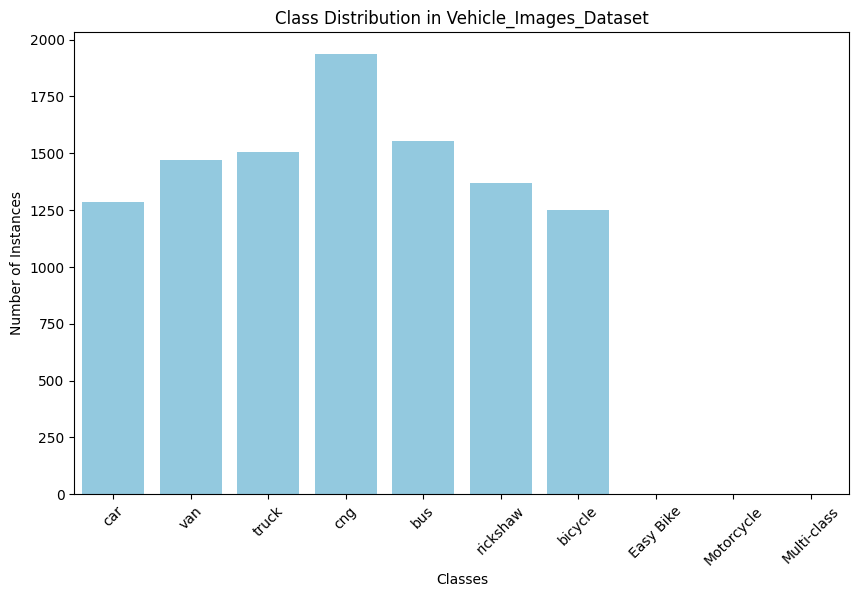

Class Counts: Counter({2: 1936, 1: 1556, 8: 1504, 9: 1470, 7: 1368, 3: 1285, 0: 1251, 4: 0, 5: 0, 6: 0})


In [110]:
import os
import xml.etree.ElementTree as ET
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

# Define the path to your dataset (this is the parent folder containing all class folders like 'Bicycle', 'Car', etc.)
dataset_path = '/content/Vehicle_Images_Dataset/Final Public Dataset/After Augmentation'  # Update this path

# Define class names
class_names = [
    "bicycle", "bus", "cng", "car", "Easy Bike", "Motorcycle",
    "Multi-class", "rickshaw", "truck", "van"
]
# Count occurrences of each class in labels
class_counts = Counter()

# Walk through all class subfolders in the dataset
for root, dirs, files in os.walk(dataset_path):
    for dir_name in dirs:
        # Skip non-class folders (like 'Images' or 'Labels')
        if dir_name == "Images" or dir_name == "Labels":
            continue

        class_folder = os.path.join(root, dir_name)  # Folder like '/Bicycle', '/Car', etc.

        # Iterate over the files in each class folder
        for label_file in os.listdir(class_folder):
            if label_file.endswith(".xml"):  # Only process XML label files
                label_file_path = os.path.join(class_folder, label_file)

                # Parse the XML file to count class occurrences
                tree = ET.parse(label_file_path)
                root_element = tree.getroot()

                # Assuming the object class names are stored in a tag like <name> in the XML file
                for obj in root_element.findall('object'):
                    class_name = obj.find('name').text  # Extract class name from XML
                    if class_name in class_names:
                        class_id = class_names.index(class_name)  # Get class index
                        class_counts[class_id] += 1

# Ensure all classes are represented in the class counts
for i in range(len(class_names)):
    if i not in class_counts:
        class_counts[i] = 0

# Plot class distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=[class_names[c] for c in class_counts.keys()], y=list(class_counts.values()), color="skyblue")
plt.xlabel("Classes")
plt.ylabel("Number of Instances")
plt.title("Class Distribution in Vehicle_Images_Dataset")
plt.xticks(rotation=45)
plt.show()

# Print class counts for debugging
print("Class Counts:", class_counts)


In [99]:
import os

# Define the path to your dataset
source_dir = '/content/Vehicle_Images_Dataset/Final Public Dataset/After Augmentation'

# List all the subdirectories (class folders) in the source directory
class_folders = [folder for folder in os.listdir(source_dir) if os.path.isdir(os.path.join(source_dir, folder))]

# Print the class names (folder names)
print("Class names found:")
for class_name in class_folders:
    print(class_name)


Class names found:
Car
Van
Easy bike
Multi-Class
Labels_TXT
Bicycle
CNG
Bus
Rickshaw
Main_Images
Motorcycle
Truck


# Main Body

In [ ]:
!pip install yolov10

In [ ]:
from ultralytics import YOLO
model = YOLO('yolov10n.pt')

In [ ]:
results = model(source = "/content/RSUD20k/images/train/train0.jpg", show =True, conf =0.4, save = True)


In [ ]:
from ultralytics import YOLO

model = YOLO('yolov10n.pt')



In [ ]:
!yolo task=detect mode=train model="/content/yolov10n.pt" data="/content/data.yaml" epochs=10 imgsz=640


In [ ]:
from ultralytics import YOLO

model = YOLO('yolov9t.pt')

In [ ]:
results = model(source = "/content/RSUD20k/images/train/train1003.jpg", show =True, conf =0.4, save = True)


In [ ]:
!yolo predict model="/content/yolov9t.pt" source = "/content/mixed (101).jpg"

In [ ]:
!yolo task=segment mode=predict model="/content/yolo11x-seg.pt" source = "/content/mixed (101).jpg"

DONT RUN THE BELOW CODES


In [ ]:
from google.colab import files

# Path to the trained model (best model or last model)
model_path = '/content/runs/detect/train11/weights/best.pt'  # or use 'last.pt' if you prefer

# Download the model
files.download(model_path)


In [ ]:
!yolo task=segment mode=predict model="/content/yolov8n-seg.pt" source = "/content/HHHHGG.mp4"

In [ ]:
from google.colab import files

# Path to the video file you want to download
video_path = '/content/runs/segment/predict6/HHHHGG.avi'

# Download the video file
files.download(video_path)


In [ ]:
!yolo predict model="/content/yolov8n.pt" source = "/content/HHHHGG.mp4"

In [ ]:
!pip freeze > requirements.txt